# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '10'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_rime_ice_snow.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2557985)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 19:13:42 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_ice.values
    ni   = xr.open_dataset(fname).n_ice.values
    cwc  = xr.open_dataset(fname).cwc.values
    r_c  = xr.open_dataset(fname).rc.values    
    # process rates
    rime_ice_cloud_num   = xr.open_dataset(fname).rime_ice_cloud_num.values
    rime_ice_cloud_mass  = xr.open_dataset(fname).rime_ice_cloud_mass.values
    rime_ice_cloud_rmass = xr.open_dataset(fname).rime_ice_cloud_rmass.values
    rime_ice_cloud_rvol  = xr.open_dataset(fname).rime_ice_cloud_rvol.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*ni)
    cwc = np.log(cwc, where=cwc>q_min, out=np.nan*ni)
    r_c = np.log(r_c, where=r_c>q_min, out=np.nan*ni)
    rime_ice_cloud_num  = np.log(rime_ice_cloud_num,  where=rime_ice_cloud_num>p_min,  out=np.nan*rime_ice_cloud_num)    
    rime_ice_cloud_mass = np.log(rime_ice_cloud_mass, where=rime_ice_cloud_mass>p_min, out=np.nan*rime_ice_cloud_mass)
    rime_ice_cloud_rmass = np.log(rime_ice_cloud_rmass,where=rime_ice_cloud_rmass>p_min, out=np.nan*rime_ice_cloud_rmass)
    rime_ice_cloud_rvol  = np.log(rime_ice_cloud_rvol, where=rime_ice_cloud_rvol>p_min, out=np.nan*rime_ice_cloud_rvol)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, cwc, r_c, temp, rho, rime_ice_cloud_num, rime_ice_cloud_mass, rime_ice_cloud_rmass, rime_ice_cloud_rvol ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'cwc', 'rc', 'temp', 'rho', 'rime_ice_cloud_num', 'rime_ice_cloud_mass', 'rime_ice_cloud_rmass', 'rime_ice_cloud_rvol' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi        ni        cwc         rc        temp    rho  \
186 -13.831924  6.156174  -8.772085 -12.155304  265.890015  1.038   
188 -17.973434  5.668639  -9.581404 -12.155304  266.410004  1.047   
189 -17.353043  6.088455 -10.104381 -12.155304  266.690002  1.052   
196 -15.550738  7.278284  -9.079312 -12.155304  268.779999  1.090   
202 -14.858045  7.371804  -8.852666 -12.155304  270.959991  1.130   

     rime_ice_cloud_num  rime_ice_cloud_mass  rime_ice_cloud_rmass  \
186            3.583344           -16.286123            -21.297894   
188           -3.465736           -23.783794            -28.734221   
189           -3.688879           -23.769751            -29.546801   
196           -1.086190           -22.691938            -29.164030   
202            0.677516           -20.875042            -23.826551   

     rime_ice_cloud_rvol  
186           -26.308529  
188           -33.744858  
189           -34.557438  
196           -34.174660  
202           -28.837187

In [10]:
dataset_train.describe()

qi            ni           cwc            rc          temp  \
count  13460.000000  13460.000000  13460.000000  13460.000000  13460.000000   
mean     -14.058904      7.131088     -8.326102    -11.155183    263.397003   
std        4.030097      3.909127      1.640464      0.466716      6.831634   
min      -32.388363    -11.849392    -26.978697    -12.203955    245.809998   
25%      -16.436279      5.207051     -9.246227    -11.457935    258.637512   
50%      -13.586664      7.372244     -8.302082    -11.171025    265.000000   
75%      -11.183190      9.526865     -7.312720    -10.794774    268.720001   
max       -4.741597     18.243597     -3.947650    -10.260991    273.140015   

                rho  rime_ice_cloud_num  rime_ice_cloud_mass  \
count  13460.000000        13460.000000         13460.000000   
mean       0.980343           -1.283366           -21.714291   
std        0.110732            4.107011             4.250732   
min        0.711000          -16.801191           -37.770638   
25%        0.900000           -3.997614           -24.506691   
50%        0.993000           -1.092091           -21.289913   
75%        1.065000            1.629241           -18.601969   
max        1.281000           11.367631           -10.570655   

       rime_ice_cloud_rmass  rime_ice_cloud_rvol  
count          13460.000000         13460.000000  
mean             -24.305637           -29.431721  
std                4.621421             4.669144  
min              -40.906139           -45.916767  
25%              -27.481428           -32.640439  
50%              -23.937538           -29.067100  
75%              -20.886943           -25.982926  
max              -11.852402           -16.863037

In [11]:
dataset_test.describe()

qi           ni          cwc           rc         temp  \
count  2810.000000  2810.000000  2810.000000  2810.000000  2810.000000   
mean    -14.018563     7.151618    -8.343203   -11.138981   263.380768   
std       4.160500     4.064370     1.575953     0.450405     6.974315   
min     -33.734177   -14.357827   -28.603882   -12.201623   246.089996   
25%     -16.530024     5.102413    -9.245969   -11.436205   258.522491   
50%     -13.445086     7.468171    -8.326572   -11.146420   265.214996   
75%     -11.032214     9.630710    -7.374963   -10.796052   268.877502   
max      -4.537792    18.079147    -4.431217   -10.261938   273.140015   

               rho  rime_ice_cloud_num  rime_ice_cloud_mass  \
count  2810.000000         2810.000000          2810.000000   
mean      0.979888           -1.378050           -21.814310   
std       0.112533            4.173977             4.305891   
min       0.713000          -16.660421           -38.009876   
25%       0.894000           -4.079958           -24.587392   
50%       0.993000           -1.140904           -21.398672   
75%       1.067000            1.548186           -18.698020   
max       1.273000           10.967922            -9.903576   

       rime_ice_cloud_rmass  rime_ice_cloud_rvol  
count           2810.000000          2810.000000  
mean             -24.397314           -29.522779  
std                4.627173             4.676885  
min              -40.444420           -45.455055  
25%              -27.446431           -32.637293  
50%              -24.085061           -29.260223  
75%              -20.935092           -26.071399  
max              -11.782825           -16.793459

In [12]:
dataset_val.describe()

qi           ni          cwc           rc         temp  \
count  2800.000000  2800.000000  2800.000000  2800.000000  2800.000000   
mean    -14.070815     7.085982    -8.305582   -11.141286   263.487183   
std       4.044415     3.913182     1.524760     0.460998     6.811319   
min     -29.586689    -9.463531   -25.992025   -12.191874   245.740005   
25%     -16.439677     5.105794    -9.263741   -11.456594   258.864998   
50%     -13.496549     7.442639    -8.268384   -11.166107   265.195007   
75%     -11.176026     9.479506    -7.310475   -10.774834   268.855003   
max      -5.327870    17.508532    -3.872802   -10.267930   273.140015   

               rho  rime_ice_cloud_num  rime_ice_cloud_mass  \
count  2800.000000         2800.000000          2800.000000   
mean      0.981887           -1.345947           -21.760878   
std       0.110319            4.142058             4.268049   
min       0.718000          -16.395727           -37.971256   
25%       0.902000           -3.976562           -24.494813   
50%       0.994000           -1.119906           -21.406875   
75%       1.067000            1.652239           -18.581346   
max       1.273000           11.695147            -9.922880   

       rime_ice_cloud_rmass  rime_ice_cloud_rvol  
count           2800.000000          2800.000000  
mean             -24.337515           -29.455307  
std                4.583629             4.626960  
min              -40.836452           -45.851032  
25%              -27.410552           -32.574780  
50%              -23.978182           -29.078149  
75%              -20.899617           -25.979414  
max              -11.591220           -16.601856

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['cwc'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi            ni           cwc            rc          temp  \
count  12059.000000  12059.000000  12059.000000  12059.000000  12059.000000   
mean     -13.240445      7.917444     -8.349632    -11.129292    262.825104   
std        3.153497      3.061798      1.389291      0.460023      6.855177   
min      -19.997265     -0.770439    -14.063972    -12.203955    245.809998   
25%      -15.554830      5.876699     -9.292093    -11.431078    257.705002   
50%      -13.144967      7.730043     -8.360189    -11.147414    264.470001   
75%      -10.889825      9.873518     -7.389022    -10.769080    268.209991   
max       -4.741597     18.243597     -3.947650    -10.260991    273.000000   

                rho  rime_ice_cloud_num  rime_ice_cloud_mass  \
count  12059.000000        12059.000000         12059.000000   
mean       0.971455           -0.670619           -21.045174   
std        0.110444            3.709417             3.767368   
min        0.711000          -16.801191           -37.770638   
25%        0.887000           -3.203372           -23.539131   
50%        0.982000           -0.623739           -20.833145   
75%        1.056000            1.909078           -18.340545   
max        1.281000           11.367631           -10.570655   

       rime_ice_cloud_rmass  rime_ice_cloud_rvol  
count          12059.000000         12059.000000  
mean             -23.625282           -28.727682  
std                4.189954             4.233268  
min              -40.906139           -45.916767  
25%              -26.450925           -31.610106  
50%              -23.371235           -28.477432  
75%              -20.569023           -25.654012  
max              -11.852402           -16.863037

In [16]:
dataset_test.describe()

qi           ni          cwc           rc         temp  \
count  2495.000000  2495.000000  2495.000000  2495.000000  2495.000000   
mean    -13.140578     8.001256    -8.381780   -11.109469   262.735809   
std       3.222626     3.138471     1.348631     0.442988     7.000692   
min     -19.957380    -0.218430   -12.652360   -12.200369   246.089996   
25%     -15.534456     5.853020    -9.305201   -11.400338   257.019989   
50%     -13.014361     7.846120    -8.386165   -11.121539   264.510010   
75%     -10.800809    10.021112    -7.492049   -10.772323   268.375000   
max      -4.537792    18.079147    -4.431217   -10.261938   273.000000   

               rho  rime_ice_cloud_num  rime_ice_cloud_mass  \
count  2495.000000         2495.000000          2495.000000   
mean      0.970313           -0.746561           -21.125238   
std       0.112577            3.760750             3.816226   
min       0.713000          -16.660421           -38.009876   
25%       0.878000           -3.267922           -23.690614   
50%       0.983000           -0.693147           -20.942261   
75%       1.056000            1.856298           -18.320650   
max       1.273000           10.967922            -9.903576   

       rime_ice_cloud_rmass  rime_ice_cloud_rvol  
count           2495.000000          2495.000000  
mean             -23.689648           -28.783998  
std                4.171816             4.215518  
min              -40.444420           -45.455055  
25%              -26.582251           -31.763369  
50%              -23.472664           -28.593416  
75%              -20.537148           -25.626999  
max              -11.782825           -16.793459

### Pairplot

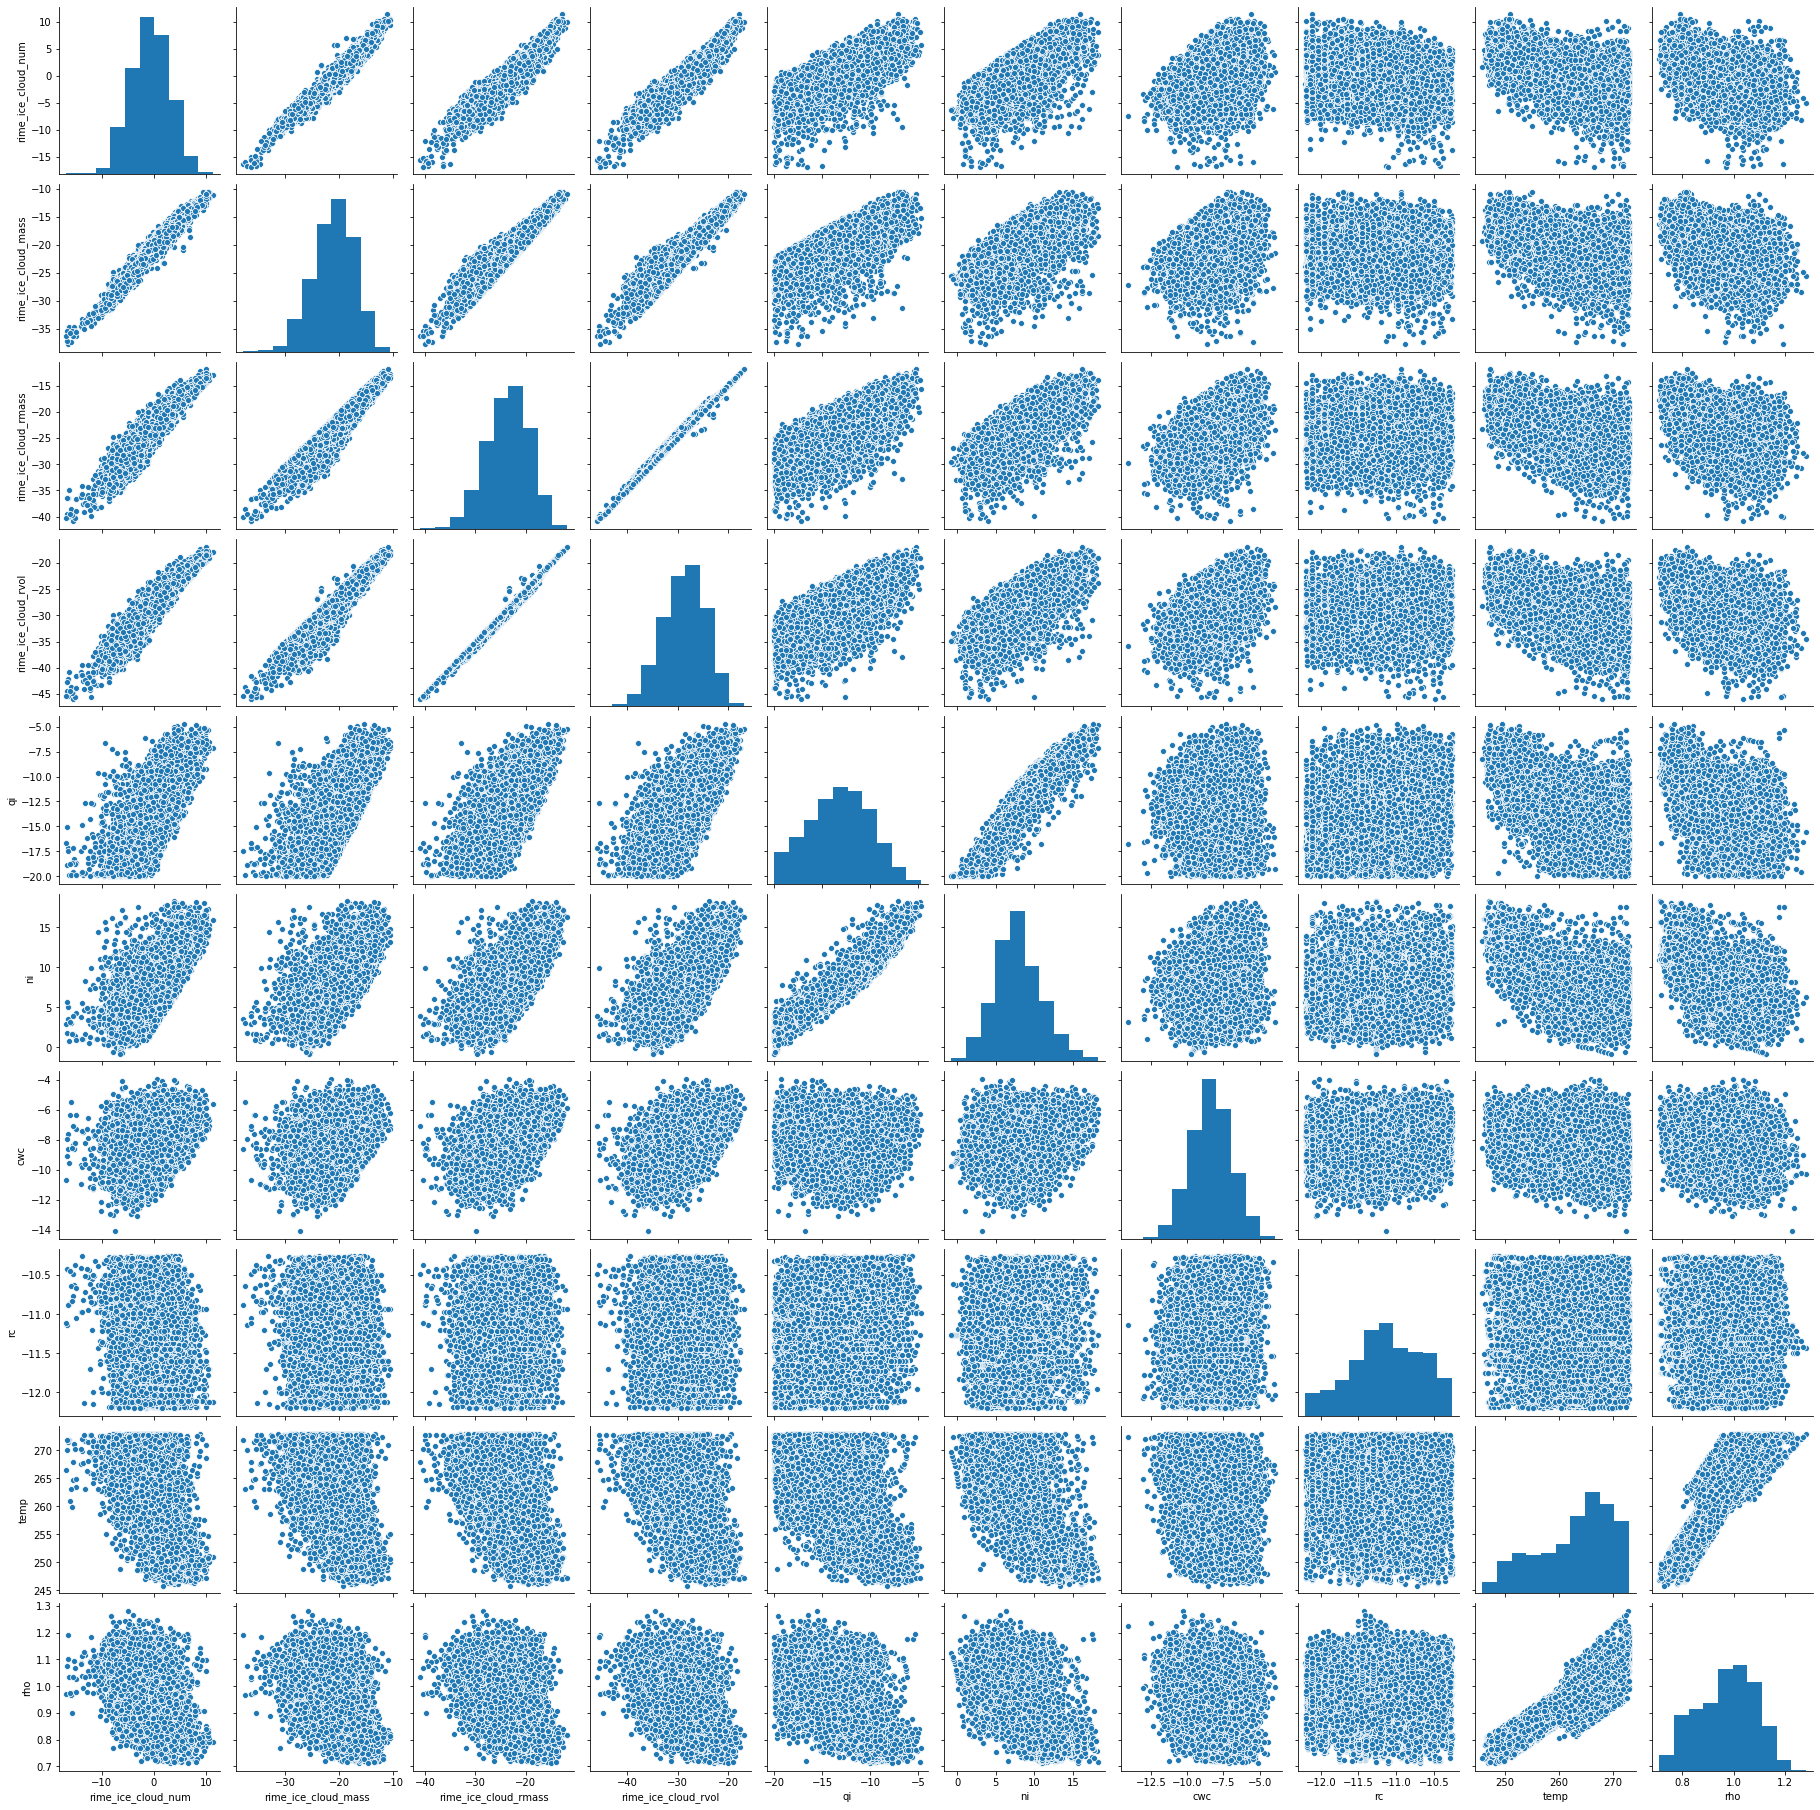

In [17]:
sns.pairplot(dataset_train[["rime_ice_cloud_num","rime_ice_cloud_mass","rime_ice_cloud_rmass","rime_ice_cloud_rvol","qi","ni","cwc","rc","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [21]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [22]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [23]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("rime_ice_cloud_num")
train_stats1.pop("rime_ice_cloud_mass")
train_stats1.pop("rime_ice_cloud_rmass")
train_stats1.pop("rime_ice_cloud_rvol")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
qi   12059.0 -13.240445  3.153497 -19.997265 -15.554830 -13.144967 -10.889825   
ni   12059.0   7.917444  3.061798  -0.770439   5.876699   7.730043   9.873518   
cwc  12059.0  -8.349632  1.389291 -14.063972  -9.292093  -8.360189  -7.389022   
rc   12059.0 -11.129292  0.460023 -12.203955 -11.431078 -11.147414 -10.769080   

           max  
qi   -4.741597  
ni   18.243597  
cwc  -3.947650  
rc  -10.260991

In [25]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("rime_ice_cloud_num")
train_stats2.pop("rime_ice_cloud_mass")
train_stats2.pop("rime_ice_cloud_rmass")
train_stats2.pop("rime_ice_cloud_rvol")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
qi    12059.0  -13.240445  3.153497  -19.997265  -15.554830  -13.144967   
ni    12059.0    7.917444  3.061798   -0.770439    5.876699    7.730043   
cwc   12059.0   -8.349632  1.389291  -14.063972   -9.292093   -8.360189   
rc    12059.0  -11.129292  0.460023  -12.203955  -11.431078  -11.147414   
temp  12059.0  262.825104  6.855177  245.809998  257.705002  264.470001   

             75%         max  
qi    -10.889825   -4.741597  
ni      9.873518   18.243597  
cwc    -7.389022   -3.947650  
rc    -10.769080  -10.260991  
temp  268.209991  273.000000

In [26]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("rime_ice_cloud_num")
train_stats3.pop("rime_ice_cloud_mass")
train_stats3.pop("rime_ice_cloud_rmass")
train_stats3.pop("rime_ice_cloud_rvol")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
qi    12059.0  -13.240445  3.153497  -19.997265  -15.554830  -13.144967   
ni    12059.0    7.917444  3.061798   -0.770439    5.876699    7.730043   
cwc   12059.0   -8.349632  1.389291  -14.063972   -9.292093   -8.360189   
rc    12059.0  -11.129292  0.460023  -12.203955  -11.431078  -11.147414   
temp  12059.0  262.825104  6.855177  245.809998  257.705002  264.470001   
rho   12059.0    0.971455  0.110444    0.711000    0.887000    0.982000   

             75%         max  
qi    -10.889825   -4.741597  
ni      9.873518   18.243597  
cwc    -7.389022   -3.947650  
rc    -10.769080  -10.260991  
temp  268.209991  273.000000  
rho     1.056000    1.281000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [27]:
# pop does not work for multiple columns, use copy instead

labels = ['rime_ice_cloud_num','rime_ice_cloud_mass','rime_ice_cloud_rmass','rime_ice_cloud_rvol']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [28]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [30]:
train_labels.describe()

rime_ice_cloud_num  rime_ice_cloud_mass  rime_ice_cloud_rmass  \
count        12059.000000         12059.000000          12059.000000   
mean            -0.670619           -21.045174            -23.625282   
std              3.709417             3.767368              4.189954   
min            -16.801191           -37.770638            -40.906139   
25%             -3.203372           -23.539131            -26.450925   
50%             -0.623739           -20.833145            -23.371235   
75%              1.909078           -18.340545            -20.569023   
max             11.367631           -10.570655            -11.852402   

       rime_ice_cloud_rvol  
count         12059.000000  
mean            -28.727682  
std               4.233268  
min             -45.916767  
25%             -31.610106  
50%             -28.477432  
75%             -25.654012  
max             -16.863037

In [31]:
train_dataset1.describe()

qi            ni           cwc            rc
count  12059.000000  12059.000000  12059.000000  12059.000000
mean     -13.240445      7.917444     -8.349632    -11.129292
std        3.153497      3.061798      1.389291      0.460023
min      -19.997265     -0.770439    -14.063972    -12.203955
25%      -15.554830      5.876699     -9.292093    -11.431078
50%      -13.144967      7.730043     -8.360189    -11.147414
75%      -10.889825      9.873518     -7.389022    -10.769080
max       -4.741597     18.243597     -3.947650    -10.260991

In [32]:
train_dataset2.describe()

qi            ni           cwc            rc          temp
count  12059.000000  12059.000000  12059.000000  12059.000000  12059.000000
mean     -13.240445      7.917444     -8.349632    -11.129292    262.825104
std        3.153497      3.061798      1.389291      0.460023      6.855177
min      -19.997265     -0.770439    -14.063972    -12.203955    245.809998
25%      -15.554830      5.876699     -9.292093    -11.431078    257.705002
50%      -13.144967      7.730043     -8.360189    -11.147414    264.470001
75%      -10.889825      9.873518     -7.389022    -10.769080    268.209991
max       -4.741597     18.243597     -3.947650    -10.260991    273.000000

In [33]:
train_dataset3.describe()

qi            ni           cwc            rc          temp  \
count  12059.000000  12059.000000  12059.000000  12059.000000  12059.000000   
mean     -13.240445      7.917444     -8.349632    -11.129292    262.825104   
std        3.153497      3.061798      1.389291      0.460023      6.855177   
min      -19.997265     -0.770439    -14.063972    -12.203955    245.809998   
25%      -15.554830      5.876699     -9.292093    -11.431078    257.705002   
50%      -13.144967      7.730043     -8.360189    -11.147414    264.470001   
75%      -10.889825      9.873518     -7.389022    -10.769080    268.209991   
max       -4.741597     18.243597     -3.947650    -10.260991    273.000000   

                rho  
count  12059.000000  
mean       0.971455  
std        0.110444  
min        0.711000  
25%        0.887000  
50%        0.982000  
75%        1.056000  
max        1.281000

### Normalize the features

In [34]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [35]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi   12059.0 -1.948451e-07  1.0 -2.142644 -0.733911  0.030277  0.745401   
ni   12059.0 -1.968696e-07  1.0 -2.837510 -0.666519 -0.061206  0.638865   
cwc  12059.0  4.888635e-07  1.0 -4.113133 -0.678376 -0.007599  0.691439   
rc   12059.0 -5.944754e-07  1.0 -2.336103 -0.656022 -0.039393  0.783030   

          max  
qi   2.695055  
ni   3.372579  
cwc  3.168510  
rc   1.887516

In [36]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi    12059.0 -1.948451e-07  1.0 -2.142644 -0.733911  0.030277  0.745401   
ni    12059.0 -1.968696e-07  1.0 -2.837510 -0.666519 -0.061206  0.638865   
cwc   12059.0  4.888635e-07  1.0 -4.113133 -0.678376 -0.007599  0.691439   
rc    12059.0 -5.944754e-07  1.0 -2.336103 -0.656022 -0.039393  0.783030   
temp  12059.0  2.755814e-07  1.0 -2.482081 -0.746896  0.239950  0.785521   

           max  
qi    2.695055  
ni    3.372579  
cwc   3.168510  
rc    1.887516  
temp  1.484264

In [37]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    12059.0 -1.948451e-07  1.0 -2.142644 -0.733911  0.030277  0.745401   
ni    12059.0 -1.968696e-07  1.0 -2.837510 -0.666519 -0.061206  0.638865   
cwc   12059.0  4.888635e-07  1.0 -4.113133 -0.678376 -0.007599  0.691439   
rc    12059.0 -5.944754e-07  1.0 -2.336103 -0.656022 -0.039393  0.783030   
temp  12059.0  2.755814e-07  1.0 -2.482081 -0.746896  0.239950  0.785521   
rho   12059.0  7.356097e-07  1.0 -2.358245 -0.764684  0.095477  0.765497   

           max  
qi    2.695055  
ni    3.372579  
cwc   3.168510  
rc    1.887516  
temp  1.484264  
rho   2.802720

### Normalize the labels

In [38]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%  \
rime_ice_cloud_num    12059.0  -0.670619  3.709417 -16.801191  -3.203372   
rime_ice_cloud_mass   12059.0 -21.045174  3.767368 -37.770638 -23.539131   
rime_ice_cloud_rmass  12059.0 -23.625282  4.189954 -40.906139 -26.450925   
rime_ice_cloud_rvol   12059.0 -28.727682  4.233268 -45.916767 -31.610106   

                            50%        75%        max  
rime_ice_cloud_num    -0.623739   1.909078  11.367631  
rime_ice_cloud_mass  -20.833145 -18.340545 -10.570655  
rime_ice_cloud_rmass -23.371235 -20.569023 -11.852402  
rime_ice_cloud_rvol  -28.477432 -25.654012 -16.863037

In [39]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [40]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [41]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [43]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.69643766, -0.67515373,  0.01292819,  0.3672094 ],
       [-0.6871861 , -0.6715363 ,  0.01089194,  0.36743003],
       [-0.68618965, -0.6711428 ,  0.00935742,  0.36515462],
       [-0.6907785 , -0.67248404,  0.01354867,  0.36508578],
       [-0.6927036 , -0.6732579 ,  0.01429659,  0.36524642],
       [-0.6861832 , -0.67023224,  0.00605091,  0.35974282],
       [-0.72754645, -0.6797557 ,  0.01564997,  0.3734358 ],
       [-0.72612906, -0.6793479 ,  0.01438159,  0.37267536],
       [-0.7244235 , -0.6788428 ,  0.01290205,  0.37168735],
       [-0.72222847, -0.6781484 ,  0.01110888,  0.3704247 ]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [44]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [45]:
activ = "sigm"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.8391,  mae:0.7281,  mse:0.8391,  val_loss:0.5251,  val_mae:0.5606,  val_mse:0.5251,  
....................................................................................................
Epoch: 100, loss:0.1354,  mae:0.2437,  mse:0.1354,  val_loss:0.1409,  val_mae:0.2455,  val_mse:0.1409,  
....................................................................................................
Epoch: 200, loss:0.1308,  mae:0.2380,  mse:0.1308,  val_loss:0.1355,  val_mae:0.2380,  val_mse:0.1355,  
..........................

Text(0, 0.5, 'MAE')

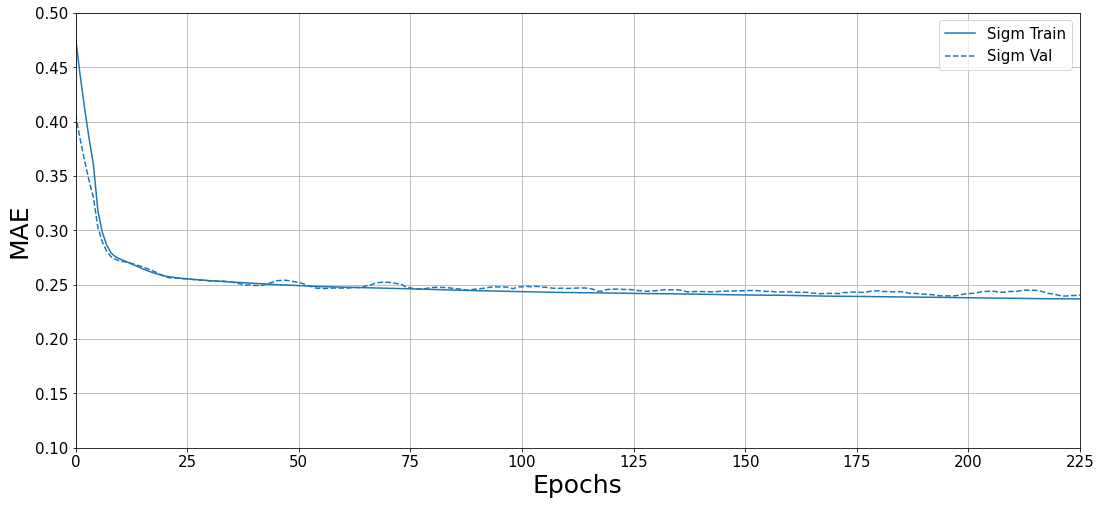

In [46]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.5])
plt.ylabel('MAE')

In [47]:
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.8002,  mae:0.7088,  mse:0.8002,  val_loss:0.4881,  val_mae:0.5348,  val_mse:0.4881,  
...............................................................................................

Text(0, 0.5, 'MAE')

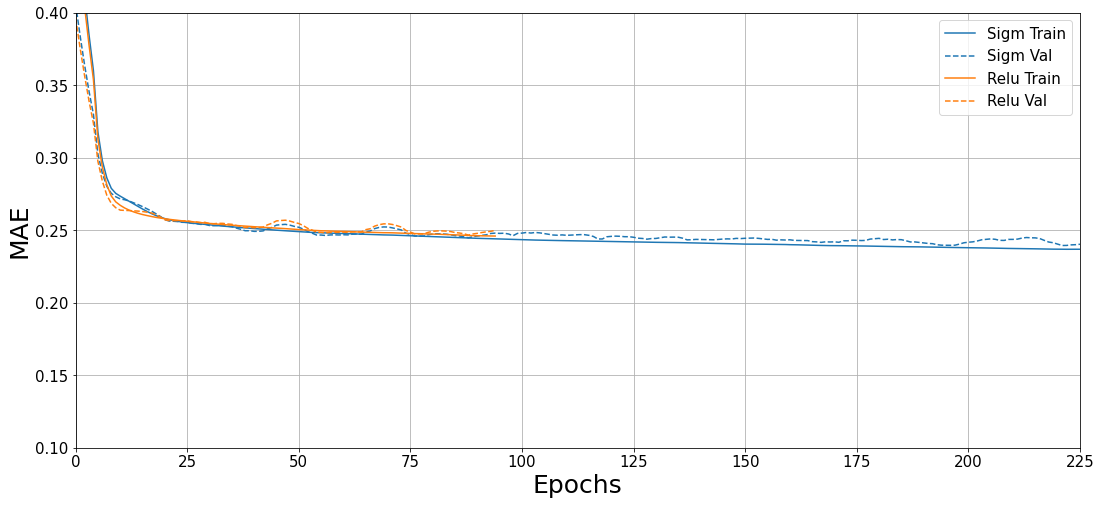

In [48]:
activ = "ReLU"
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.4])
plt.ylabel('MAE')

In [49]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.4334,  mae:0.4980,  mse:0.4334,  val_loss:0.2802,  val_mae:0.3759,  val_mse:0.2802,  
..........................................................................................

Text(0, 0.5, 'MAE')

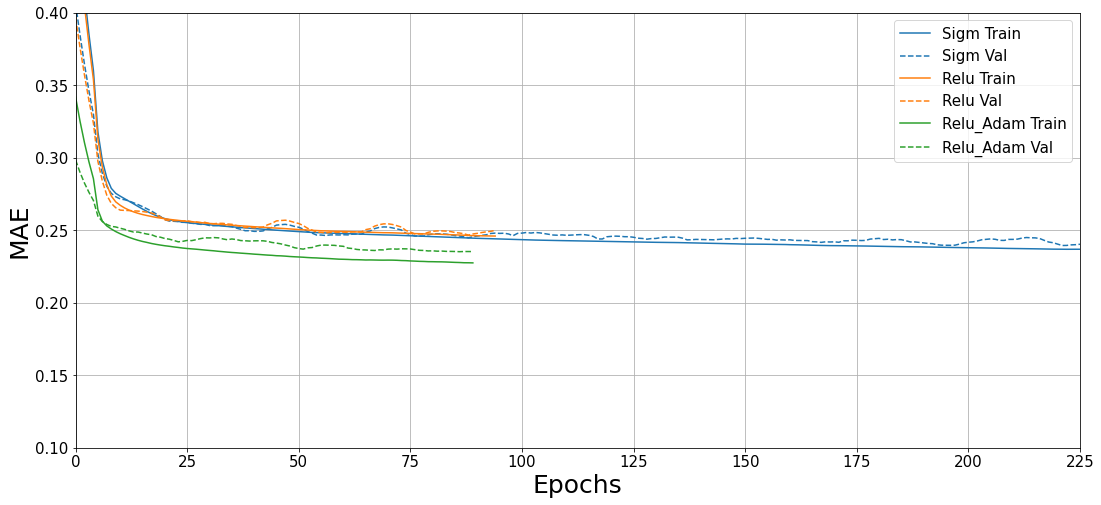

In [50]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.4])
plt.ylabel('MAE')

In [51]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3386,  mae:0.3928,  mse:0.3386,  val_loss:0.1679,  val_mae:0.2806,  val_mse:0.1679,  
.......................................................................

Text(0, 0.5, 'MAE')

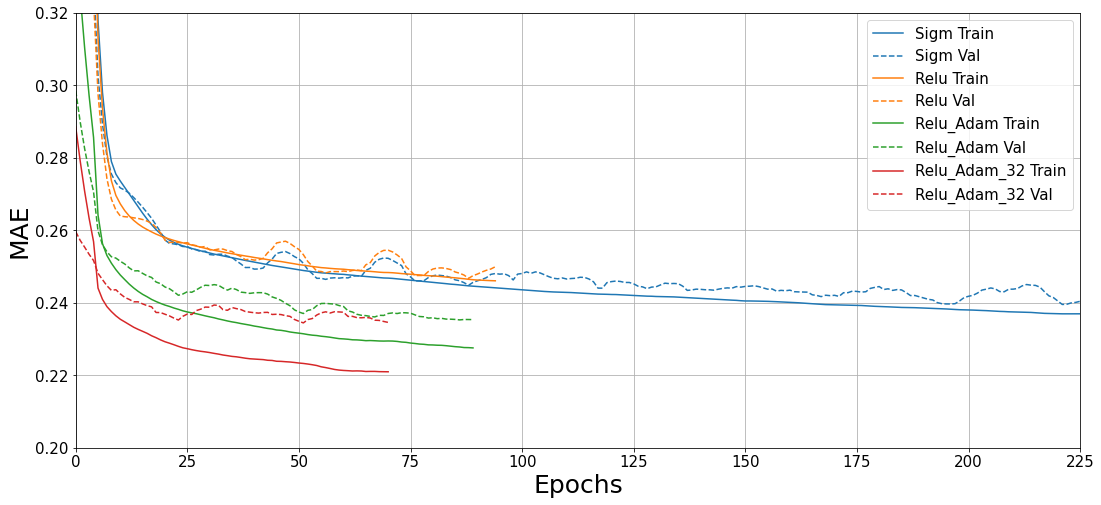

In [53]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.2, 0.32])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

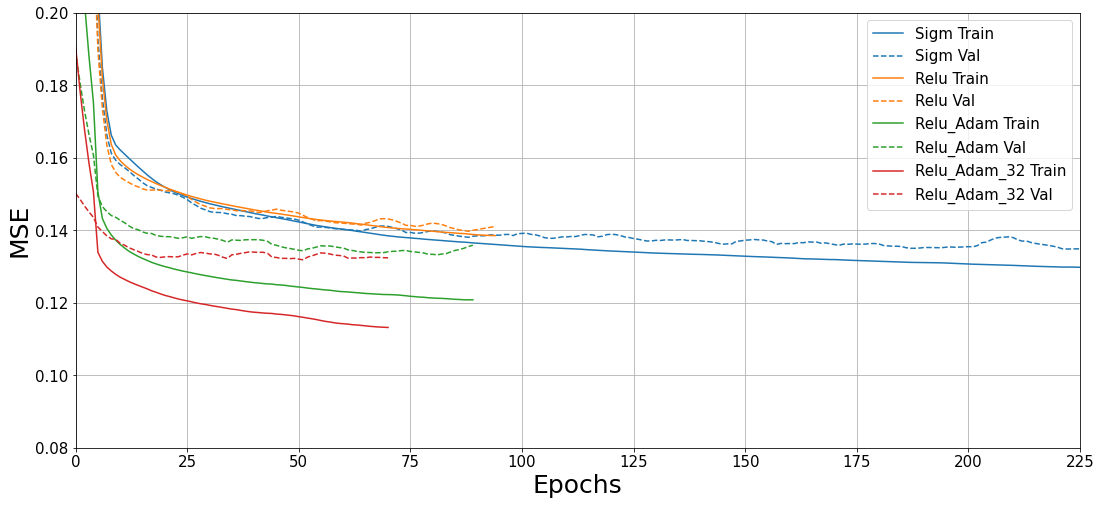

In [54]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.08, 0.2])
plt.ylabel('MSE')

In [55]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

2495/2495 - 0s - loss: 0.1407 - mae: 0.2418 - mse: 0.1407
Testing set for model 1, Mean Abs Error:    0.24179


In [56]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

2495/2495 - 0s - loss: 0.1494 - mae: 0.2495 - mse: 0.1494
Testing set for model 2, Mean Abs Error:              0.24953


In [57]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

2495/2495 - 0s - loss: 0.1354 - mae: 0.2362 - mse: 0.1354
Testing set for model 3, Mean Abs Error:              0.23616


In [58]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

2495/2495 - 0s - loss: 0.1352 - mae: 0.2375 - mse: 0.1352
Testing set for model 4, Mean Abs Error:              0.23752


In [59]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.24179365, 0.24952936, 0.23615879, 0.23751992]

In [60]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.1406685, 0.14938119, 0.13542202, 0.13521278]

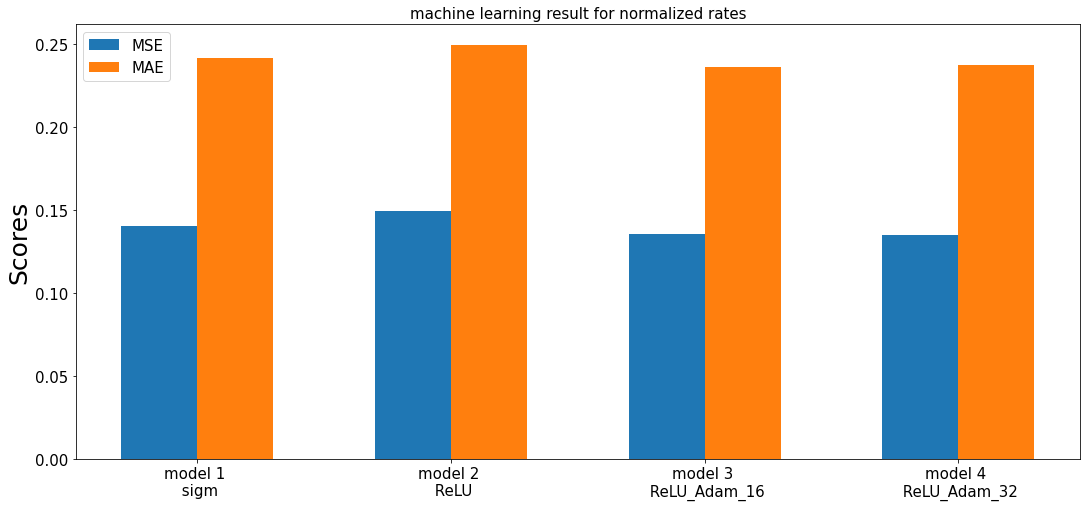

In [61]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'model 1 \n sigm',
 'model 2 \n ReLU',
 'model 3 \n ReLU_Adam_16',
 'model 4 \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [62]:
test_true_num  = np.exp(test_labels.pop('rime_ice_cloud_num'))
test_true_mass = np.exp(test_labels.pop('rime_ice_cloud_mass'))

In [63]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [64]:
labels = [ "rime_ice_cloud_num", "rime_ice_cloud_mass", "rime_ice_cloud_rmass", "rime_ice_cloud_rvol" ]

p1 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=labels)

In [65]:
p1.describe()

rime_ice_cloud_num  rime_ice_cloud_mass  rime_ice_cloud_rmass  \
count         2495.000000          2495.000000           2495.000000   
mean            -0.001377             0.010383              0.016396   
std              0.966112             0.948202              0.930244   
min             -2.665589            -2.539586             -2.610273   
25%             -0.733960            -0.735863             -0.728691   
50%             -0.017058             0.066906              0.054213   
75%              0.695580             0.710793              0.702777   
max              3.062769             2.971633              2.873338   

       rime_ice_cloud_rvol  
count          2495.000000  
mean              0.005962  
std               0.933490  
min              -2.569018  
25%              -0.740487  
50%               0.040464  
75%               0.693644  
max               2.819421

In [66]:
train_labels_stats

count       mean       std        min        25%  \
rime_ice_cloud_num    12059.0  -0.670619  3.709417 -16.801191  -3.203372   
rime_ice_cloud_mass   12059.0 -21.045174  3.767368 -37.770638 -23.539131   
rime_ice_cloud_rmass  12059.0 -23.625282  4.189954 -40.906139 -26.450925   
rime_ice_cloud_rvol   12059.0 -28.727682  4.233268 -45.916767 -31.610106   

                            50%        75%        max  
rime_ice_cloud_num    -0.623739   1.909078  11.367631  
rime_ice_cloud_mass  -20.833145 -18.340545 -10.570655  
rime_ice_cloud_rmass -23.371235 -20.569023 -11.852402  
rime_ice_cloud_rvol  -28.477432 -25.654012 -16.863037

In [67]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [68]:
test_predict1.describe()

rime_ice_cloud_num  rime_ice_cloud_mass  rime_ice_cloud_rmass  \
count         2495.000000         2.495000e+03          2.495000e+03   
mean           121.406292         9.329727e-08          1.727454e-08   
std           1422.965332         1.177018e-06          2.170045e-07   
min              0.000026         5.070621e-14          9.768446e-16   
25%              0.033602         4.531245e-11          2.592327e-12   
50%              0.480036         9.325347e-10          6.891616e-11   
75%              6.750252         1.054774e-08          1.043511e-09   
max          43935.061698         5.275036e-05          9.294127e-06   

       rime_ice_cloud_rvol  
count         2.495000e+03  
mean          1.025639e-10  
std           1.216153e-09  
min           6.318677e-18  
25%           1.453292e-14  
50%           3.963867e-13  
75%           6.294789e-12  
max           5.095516e-08

In [69]:
np.exp(test_dataset1.head())

qi           ni       cwc        rc
187  2.169701e-08   156.660034  0.000107  0.000005
394  1.528900e-05  8368.798828  0.000150  0.000014
399  1.982200e-05  6171.901367  0.000017  0.000014
412  1.072100e-05  3036.000244  0.000515  0.000014
417  1.329100e-06  2175.299805  0.000015  0.000014

In [70]:
test_predict1.head()

rime_ice_cloud_num  rime_ice_cloud_mass  rime_ice_cloud_rmass  \
0            0.025573         8.352424e-12          2.689818e-13   
1           12.070038         2.434717e-08          1.274080e-09   
2            0.468879         2.017070e-09          4.692857e-11   
3          138.656994         2.450928e-07          1.793865e-08   
4            0.009756         1.809910e-11          3.340346e-13   

   rime_ice_cloud_rvol  
0         2.129876e-15  
1         7.717547e-12  
2         2.678177e-13  
3         1.053390e-10  
4         2.237395e-15

In [71]:
test_dataset2.head()

qi        ni        cwc         rc        temp
187 -17.646091  5.054078  -9.142682 -12.155304  266.140015
394 -11.088377  9.032266  -8.804875 -11.148866  261.670013
399 -10.828718  8.727762 -10.953310 -11.148866  262.790009
412 -11.443306  8.018296  -7.571343 -11.148866  266.049988
417 -13.531009  7.684922 -11.134489 -11.148866  267.880005

In [72]:
test_predict1_num  = test_predict1['rime_ice_cloud_num']
test_predict1_mass = test_predict1['rime_ice_cloud_mass']

In [73]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data3), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['rime_ice_cloud_num']
test_predict2_mass = test_predict2['rime_ice_cloud_mass']


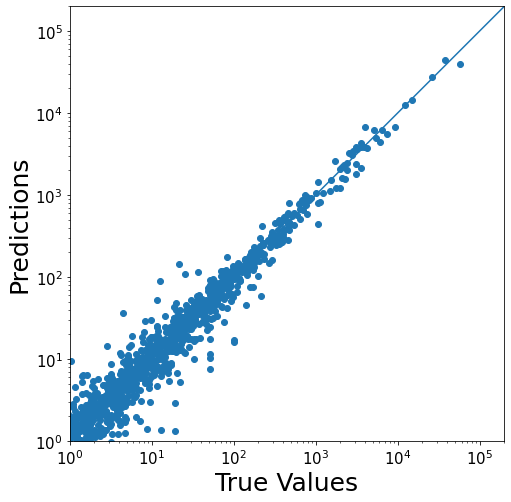

In [74]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e0, 2e5

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

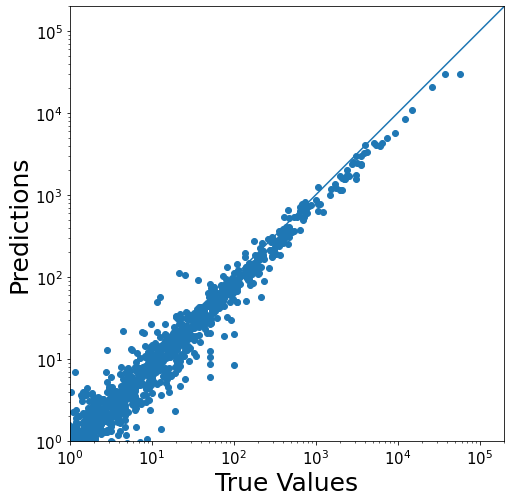

In [75]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

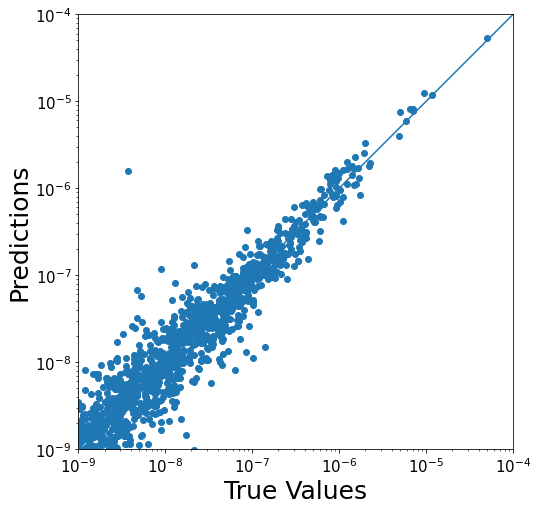

In [76]:
amin, amax = 1e-9, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

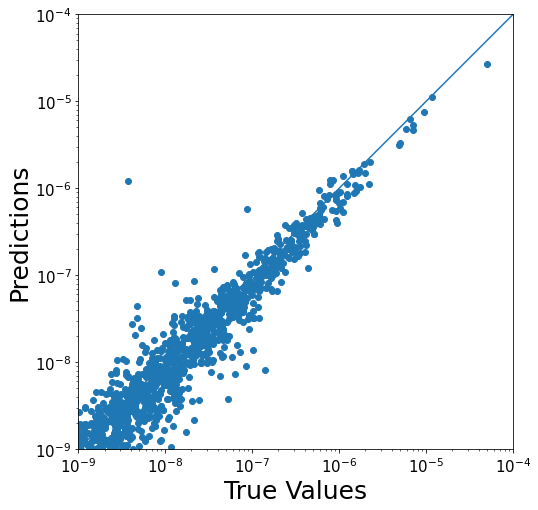

In [77]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [78]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [79]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [80]:
labels   = 'rime_ice_cloud_num, rime_ice_cloud_mass, rime_ice_cloud_rmass, rime_ice_cloud_rvol'
features = 'qi, ni, cwc, rc, T, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)

filename = 'saved_model_v2/rime_ice_cloud_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_ice_cloud_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_ice_cloud_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)



Saving model to saved_model_v2/rime_ice_cloud_model2_10.nc
  Features:   qi, ni, cwc, rc, T, rho
  Labels:     rime_ice_cloud_num, rime_ice_cloud_mass, rime_ice_cloud_rmass, rime_ice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: sigmoid
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: sigmoid
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/rime_ice_cloud_model3_10.nc
  Features:   qi, ni, cwc, rc, T, rho
  Labels:     rime_ice_cloud_num, rime_ice_cloud_mass, rime_ice_cloud_rmass, rime_ice_cloud_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Den